In [3]:
import os
import pickle

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    TOML_PATH,
    DATA_PATH,
    BUILD_DIR,
)


In [4]:
src = os.path.join(BUILD_DIR, "inference.pkl")
with open(src, "rb") as f:
    COMBINED_COMBINATIONS, COMBINED_POSTERIOR_SAMPLES = pickle.load(f)

DATA = pd.read_csv(DATA_PATH)
print(DATA.shape)

config = Config(TOML_PATH)
model = NonHierarchicalBayesianModel(config)


(7676, 44)


In [5]:
combinations = [
    u for u in COMBINED_COMBINATIONS
    if "" in u[1].split("-")
]

ind = [u in combinations for u in COMBINED_COMBINATIONS]
combinations = [u for u, v in zip(COMBINED_COMBINATIONS, ind) if v]
posterior_samples = {u: v[:, ind, ...] for u, v in COMBINED_POSTERIOR_SAMPLES.items()}


In [6]:
subjects = sorted(DATA["participant"].unique().tolist())
directions = ["-M", "-L"]
segments = ["C5", "C6", "C7", "C8"]

a = None
a_mask = None

for subject in subjects:
    for direction in directions:
        for segment in segments:
            compound_position = f"-{segment}{direction[-1]}"
            curr_combination = (subject, compound_position)

            if curr_combination in combinations:
                ind = [c == curr_combination for c in combinations]
                assert sum(ind) == 1
                if a is None:
                    a = posterior_samples[site.a][:, ind, ...]
                    a_mask = np.full(a.shape, False)
                else:
                    a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
                    a_mask = np.concatenate(
                        [
                            a_mask,
                            np.full(
                                (
                                    posterior_samples[site.a].shape[0],
                                    1,
                                    posterior_samples[site.a].shape[-1]
                                ),
                                False
                            )
                        ],
                        axis=1
                    )
            else:
                if a is None:
                    a = np.zeros((
                        posterior_samples[site.a].shape[0],
                        1,
                        posterior_samples[site.a].shape[-1]
                    ))
                    a_mask = np.full(a.shape, True)
                else:
                    a = np.concatenate(
                        [
                            a,
                            np.zeros((
                                posterior_samples[site.a].shape[0],
                                1,
                                posterior_samples[site.a].shape[-1]
                            ))
                        ],
                        axis=1
                    )
                    a_mask = np.concatenate(
                        [
                            a_mask,
                            np.full(
                                (
                                    posterior_samples[site.a].shape[0],
                                    1,
                                    posterior_samples[site.a].shape[-1],
                                ),
                                True
                            ),
                        ],
                        axis=1
                    )


a = a.reshape(
    -1, len(subjects), len(directions), len(segments), *a.shape[2:]
)
a_mask = a_mask.reshape(
    -1, len(subjects), len(directions), len(segments), *a_mask.shape[2:]
)

a = ma.masked_array(a, mask=a_mask)



In [11]:
df = DATA.copy()
df.compound_position.unique()

array(['C5M-C5L', 'C5M-C6L', 'C7L-C8L', '-C5M', 'C7M-C8L', 'C8M-C8L',
       '-C8M', '-C6L', '-C7M', '-C8L', 'C7M-C8M', 'C5L-C6L', '-C5L',
       'C6L-C7L', '-C7L', 'C7M-C7L', 'C6M-C7M', 'C5M-C6M', '-C6M',
       'C6M-C7L', 'C6M-C6L'], dtype=object)

In [9]:
set([u[1] for u in combinations])

{'-C5L', '-C5M', '-C6L', '-C6M', '-C7L', '-C7M', '-C8L', '-C8M'}

In [7]:
arr = []
arr_labels = []

for l_direction_ind, l_direction in enumerate(directions):
    label = l_direction
    arr_labels.append(label)

    for r_direction_ind, r_direction in enumerate(directions):
        if l_direction_ind == r_direction_ind:
            arr.append(1)
            continue

        l_samples = a[:, :, l_direction_ind, ...].mean(axis=0)
        r_samples = a[:, :, r_direction_ind, ...].mean(axis=0)
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1, 2)).pvalue
        arr.append(pvalue)

arr = np.array(arr)
arr = arr.reshape(-1, len(arr_labels))
arr_mask = np.diag(arr)


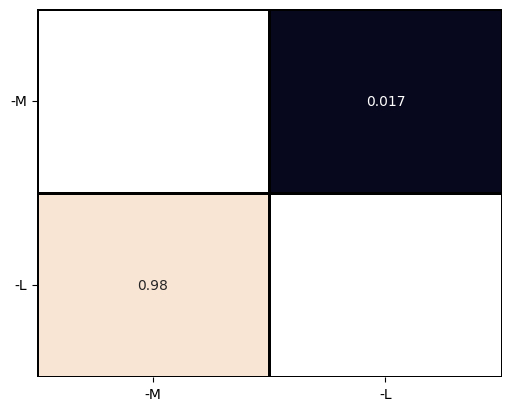

In [10]:
heatmap_kwargs = {
    "linewidths":1, "linecolor":"black", "cbar": False, "vmin": 0, "vmax": 1
}
nrows, ncols = 1, 1
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 5, nrows * 4),
    constrained_layout=True,
    squeeze=False
)
ax = axes[0, 0]
sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(arr_mask), **heatmap_kwargs)
ax.tick_params(axis="x", rotation=0)
ax.tick_params(axis="y", rotation=0)


In [12]:
combinations = [
    u for u in COMBINED_COMBINATIONS
    if "" not in u[1].split("-")
    and u[1].split("-")[0][:-1] == u[1].split("-")[1][:-1]
]

ind = [u in combinations for u in COMBINED_COMBINATIONS]
combinations = [u for u, v in zip(COMBINED_COMBINATIONS, ind) if v]
posterior_samples = {u: v[:, ind, ...] for u, v in COMBINED_POSTERIOR_SAMPLES.items()}


In [23]:
set([u[1] for u in combinations])

{'C5M-C5L', 'C6M-C6L', 'C7M-C7L', 'C8M-C8L'}

In [16]:
subjects = sorted(DATA["participant"].unique().tolist())
directions = ["-M", "-L"]
segments = ["C5", "C6", "C7", "C8"]

a = None
a_mask = None

for subject in subjects:
    for direction in directions:
        for segment in segments:
            if direction == "-M":
                compound_position = f"{segment}L-{segment}M"
            elif direction == "-L":
                compound_position = f"{segment}M-{segment}L"
            else:
                raise ValueError(f"Invalid direction: {direction}")

            curr_combination = (subject, compound_position)

            if curr_combination in combinations:
                ind = [c == curr_combination for c in combinations]
                assert sum(ind) == 1
                if a is None:
                    a = posterior_samples[site.a][:, ind, ...]
                    a_mask = np.full(a.shape, False)
                else:
                    a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
                    a_mask = np.concatenate(
                        [
                            a_mask,
                            np.full(
                                (
                                    posterior_samples[site.a].shape[0],
                                    1,
                                    posterior_samples[site.a].shape[-1]
                                ),
                                False
                            )
                        ],
                        axis=1
                    )
            else:
                if a is None:
                    a = np.zeros((
                        posterior_samples[site.a].shape[0],
                        1,
                        posterior_samples[site.a].shape[-1]
                    ))
                    a_mask = np.full(a.shape, True)
                else:
                    a = np.concatenate(
                        [
                            a,
                            np.zeros((
                                posterior_samples[site.a].shape[0],
                                1,
                                posterior_samples[site.a].shape[-1]
                            ))
                        ],
                        axis=1
                    )
                    a_mask = np.concatenate(
                        [
                            a_mask,
                            np.full(
                                (
                                    posterior_samples[site.a].shape[0],
                                    1,
                                    posterior_samples[site.a].shape[-1],
                                ),
                                True
                            ),
                        ],
                        axis=1
                    )


a = a.reshape(
    -1, len(subjects), len(directions), len(segments), *a.shape[2:]
)
a_mask = a_mask.reshape(
    -1, len(subjects), len(directions), len(segments), *a_mask.shape[2:]
)

a = ma.masked_array(a, mask=a_mask)



In [19]:
a.shape

(4000, 8, 2, 4, 6)

In [17]:
arr = []
arr_labels = []

for l_direction_ind, l_direction in enumerate(directions):
    label = l_direction
    arr_labels.append(label)

    for r_direction_ind, r_direction in enumerate(directions):
        if l_direction_ind == r_direction_ind:
            arr.append(1)
            continue

        l_samples = a[:, :, l_direction_ind, ...].mean(axis=0)
        r_samples = a[:, :, r_direction_ind, ...].mean(axis=0)
        pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1, 2)).pvalue
        arr.append(pvalue)

arr = np.array(arr)
arr = arr.reshape(-1, len(arr_labels))
arr_mask = np.diag(arr)


/tmp/ipykernel_1048468/3863313537.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1, 2)).pvalue


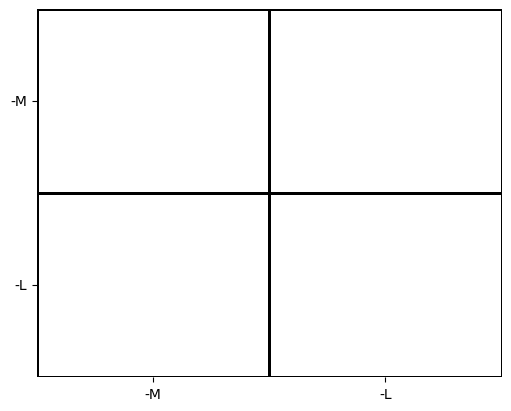

In [18]:
heatmap_kwargs = {
    "linewidths":1, "linecolor":"black", "cbar": False, "vmin": 0, "vmax": 1
}
nrows, ncols = 1, 1
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 5, nrows * 4),
    constrained_layout=True,
    squeeze=False
)
ax = axes[0, 0]
sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(arr_mask), **heatmap_kwargs)
ax.tick_params(axis="x", rotation=0)
ax.tick_params(axis="y", rotation=0)
